# Questions 2.3 à 2.5 : Deep Q-Network (DQN) pour le Trading Bitcoin

Ce notebook implémente un **agent intelligent basé sur le Deep Q-Network (DQN)** pour apprendre une stratégie de trading sur le Bitcoin.

## Objectifs
- **Question 2.3** : Définir l'architecture de l'agent, ses actions, états et récompenses.
- **Question 2.4** : Entraîner l'agent DQN sur des données réelles Bitcoin
- **Question 2.5** : Mesurer les performances (taux de succès, temps d'entraînement).

## 1. Importation des bibliothèques

Nous utilisons PyTorch pour le réseau de neurones et yfinance pour télécharger les données Bitcoin.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from ta.momentum import RSIIndicator
from ta.trend import MACD
import time
import matplotlib.pyplot as plt

## 2. Chargement et Préparation des Données

Nous téléchargeons les données historiques du Bitcoin (2018-2024) et calculons des **indicateurs techniques** :
- **log_ret** : Rendement logarithmique (variation du prix)
- **RSI** (Relative Strength Index) : Indicateur de surachat/survente
- **MACD** (Moving Average Convergence Divergence) : Indicateur de tendance

In [2]:
def get_bitcoin_data():
    print("Téléchargement des données Bitcoin...")
    df = yf.download('BTC-USD', start='2018-01-01', end='2024-01-01', interval='1d')
    
    # Correction MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df = df.astype('float32')

    df = df.dropna()
    close_series = df['Close'].squeeze()

    df['log_ret'] = np.log(close_series / close_series.shift(1))
    
    rsi = RSIIndicator(close=close_series, window=14)
    df['rsi'] = rsi.rsi() / 100.0 
    
    macd = MACD(close=close_series)
    df['macd'] = macd.macd_diff()
    
    df = df.dropna()
    
    # On s'assure une dernière fois que tout est bien en float32
    df = df.astype('float32')
    
    print(f"Données prêtes : {len(df)} jours de trading.")
    return df

## 3. Définition de l'Environnement de Trading (Question 2.3)

L'environnement simule le marché Bitcoin. L'agent interagit avec cet environnement :

### Espace d'États (5 dimensions)
1. **log_ret** : Rendement logarithmique du jour
2. **rsi** : Indicateur RSI normalisé [0,1]
3. **macd** : Valeur de l'histogramme MACD
4. **btc_held** : 0 si pas de Bitcoin, 1 si position ouverte
5. **balance_normalized** : Solde disponible normalisé

### Espace d'Actions (3 actions possibles)
- **Action 0 (HOLD)** : Ne rien faire (garder la position actuelle)
- **Action 1 (BUY)** : Acheter du Bitcoin avec tout le solde disponible
- **Action 2 (SELL)** : Vendre tout le Bitcoin détenu

### Fonction de Récompense
La récompense est la **variation de la valeur du portefeuille** :
- `reward = net_worth(t) - net_worth(t-1)`
- Récompense positive si la valeur augmente
- Récompense négative si la valeur diminue

In [3]:
class BitcoinEnv:
    def __init__(self, df, initial_balance=10000):
        self.df = df
        self.initial_balance = initial_balance
        self.reset()
        
    def reset(self):
        # Réinitialise l'état au début du dataset
        self.current_step = 0
        self.balance = self.initial_balance
        self.btc_held = 0 # 0 = Pas de BTC, >0 = Quantité de BTC
        self.net_worth = self.initial_balance
        self.history_net_worth = [self.initial_balance]
        
        return self._next_observation()
    
    def _next_observation(self):
        # Construit le vecteur d'état (State)
        # [Log_Ret, RSI, MACD, Possède_BTC?, Solde_Normalisé]
        obs = np.array([
            self.df.iloc[self.current_step]['log_ret'],
            self.df.iloc[self.current_step]['rsi'],
            self.df.iloc[self.current_step]['macd'],
            1 if self.btc_held > 0 else 0,
            self.balance / self.initial_balance # Normalisation simple
        ])
        return obs

    def step(self, action):
        # Action: 0 = Hold, 1 = Buy, 2 = Sell
        current_price = self.df.iloc[self.current_step]['Close']
        prev_net_worth = self.net_worth
        
        # Exécution de l'ordre
        if action == 1 and self.balance > 0: # BUY
            self.btc_held = self.balance / current_price
            self.balance = 0
            
        elif action == 2 and self.btc_held > 0: # SELL
            self.balance = self.btc_held * current_price
            self.btc_held = 0
            
        # Mise à jour de la valeur du portefeuille
        if self.btc_held > 0:
            self.net_worth = self.btc_held * current_price
        else:
            self.net_worth = self.balance
            
        self.history_net_worth.append(self.net_worth)
        
        # Calcul de la récompense (Variation de la valeur)
        reward = self.net_worth - prev_net_worth
        
        # Avancer d'un jour
        self.current_step += 1
        
        # Vérifier si c'est fini (fin des données)
        done = self.current_step >= len(self.df) - 1
        
        obs = self._next_observation()
        
        return obs, reward, done

## 4. Architecture du Réseau de Neurones DQN (Question 2.3)

Le réseau de neurones approxime la **fonction Q(s,a)** qui estime la valeur de chaque action dans un état donné.

### Architecture
- **Couche d'entrée** : 5 neurones (dimension de l'état)
- **Couche cachée 1** : 64 neurones + activation ReLU
- **Couche cachée 2** : 32 neurones + activation ReLU
- **Couche de sortie** : 3 neurones (Q-values pour chaque action)

### Sortie
Le réseau produit 3 **Q-values** (non normalisées) :
- Q(s, HOLD) : Valeur estimée de l'action HOLD
- Q(s, BUY) : Valeur estimée de l'action BUY  
- Q(s, SELL) : Valeur estimée de l'action SELL

L'agent choisit l'action avec la **Q-value maximale** (sauf pendant l'exploration).

In [4]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # Architecture définie dans le rapport : 5 -> 64 -> 32 -> 3
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x) # Sortie linéaire (Q-values)

## 5. Hyperparamètres et Fonction d'Entraînement (Question 2.4)

### Hyperparamètres du DQN
- **EPISODES** : 100 (nombre de fois que l'agent parcourt toute la période 2018-2024)
- **BATCH_SIZE** : 64 (taille des mini-batches pour l'apprentissage)
- **GAMMA (γ)** : 0.95 (facteur de discount pour les récompenses futures)
- **EPSILON (ε)** : Stratégie ε-greedy pour l'exploration
  - Initial : 1.0 (100% d'exploration au début)
  - Minimum : 0.01 (1% d'exploration à la fin)
  - Décroissance : 0.995 (diminution progressive)
- **LEARNING_RATE** : 0.001 (taux d'apprentissage Adam)
- **MEMORY_SIZE** : 10000 (capacité du replay buffer)

### Composants Clés du DQN
1. **Experience Replay** : Mémoire pour stocker les transitions (s, a, r, s', done)
2. **Policy Network** : Réseau utilisé pour choisir les actions
3. **Target Network** : Copie du policy network pour stabiliser l'apprentissage
4. **ε-greedy** : Équilibre exploration (actions aléatoires) vs exploitation (meilleures actions)

### Équation de Bellman
L'agent apprend en minimisant l'erreur entre :
- **Q-value prédite** : Q(s, a) du policy network
- **Q-value cible** : r + γ · max Q(s', a') du target network

In [ ]:
# Hyperparamètres
EPISODES = 100        # Nombre de fois qu'on joue tout l'historique
BATCH_SIZE = 64      # Taille du lot pour l'apprentissage
GAMMA = 0.95         # Importance du futur
EPSILON = 1.0        # Exploration initiale
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
LEARNING_RATE = 0.001
MEMORY_SIZE = 10000

# Mémoire de Répétition (Experience Replay)
memory = deque(maxlen=MEMORY_SIZE)

def train_agent():
    # 1. Charger les données (en float32 grâce à la modif précédente)
    df = get_bitcoin_data()
    env = BitcoinEnv(df)
    
    # 2. Initialiser réseaux
    state_dim = 5 
    action_dim = 3 
    
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict()) 
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    
    global EPSILON
    start_time = time.time()
    rewards_history = []
    
    print("Début de l'entraînement DQN...")
    
    for episode in range(EPISODES):
        state = env.reset()
        # On s'assure que l'état initial est un FloatTensor
        state = torch.FloatTensor(state)
        
        total_reward = 0
        done = False
        
        while not done:
            if random.random() < EPSILON:
                action = random.randint(0, 2)
            else:
                with torch.no_grad():
                    q_values = policy_net(state)
                    action = torch.argmax(q_values).item()
            
            next_state, reward, done = env.step(action)
            # Conversion explicite de l'état suivant
            next_state = torch.FloatTensor(next_state)
            
            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            
            if len(memory) > BATCH_SIZE:
                batch = random.sample(memory, BATCH_SIZE)
                
                # --- CORRECTION CRITIQUE ICI POUR LE BATCH ---
                # On force tout en float32
                states = torch.stack([x[0] for x in batch])
                actions = torch.tensor([x[1] for x in batch]).unsqueeze(1)
                
                # Les rewards doivent être explicitement float32
                rewards = torch.tensor([x[2] for x in batch], dtype=torch.float32)
                
                next_states = torch.stack([x[3] for x in batch])
                dones = torch.tensor([x[4] for x in batch], dtype=torch.bool)
                # ---------------------------------------------
                
                q_eval = policy_net(states).gather(1, actions).squeeze()
                
                with torch.no_grad():
                    q_next = target_net(next_states).max(1)[0]
                    q_next[dones] = 0.0
                    q_target = rewards + GAMMA * q_next
                
                # Maintenant q_eval et q_target sont tous les deux Float (float32)
                loss = criterion(q_eval, q_target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        target_net.load_state_dict(policy_net.state_dict())
        
        if EPSILON > EPSILON_MIN:
            EPSILON *= EPSILON_DECAY
            
        rewards_history.append(total_reward)
        
        # Print tous les 5 épisodes pour ne surcharger la console
        if (episode + 1) % 5 == 0:
            print(f"Épisode {episode+1}/{EPISODES} | Gain: {total_reward:.2f}$ | Epsilon: {EPSILON:.2f}")

    end_time = time.time()
    duration = end_time - start_time
    print(f"\nEntraînement terminé en {duration:.2f} secondes.")
    
    torch.save(policy_net.state_dict(), "dqn_bitcoin_model.pth")
    return rewards_history, duration


## 6. Exploration des Données

Avant d'entraîner l'agent, explorons les données historiques du Bitcoin pour comprendre ce que l'agent va observer.

In [6]:
df_explore = get_bitcoin_data()

print("--- Aperçu des 5 premières lignes (Inputs du réseau) ---")
# On affiche seulement les colonnes qu'on donne au réseau + le prix
cols_to_show = ['Close', 'log_ret', 'rsi', 'macd']
display(df_explore[cols_to_show].head())

print("\n--- Statistiques Descriptives ---")
display(df_explore[cols_to_show].describe())

Téléchargement des données Bitcoin...


/tmp/ipykernel_19394/238643896.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2018-01-01', end='2024-01-01', interval='1d')
[*********************100%***********************]  1 of 1 completed

Données prêtes : 2158 jours de trading.
--- Aperçu des 5 premières lignes (Inputs du réseau) ---


Price,Close,log_ret,rsi,macd
Date,,,,
2018-02-03,9174.910156,0.038233,0.322394,-163.009064
2018-02-04,8277.009766,-0.102991,0.284253,-201.033722
2018-02-05,6955.270020,-0.173982,0.239361,-289.724274
2018-02-06,7754.000000,0.108709,0.310252,-269.538116
2018-02-07,7621.299805,-0.017262,0.305163,-240.995743



--- Statistiques Descriptives ---


Price,Close,log_ret,rsi,macd
count,2158.000000,2158.000000,2158.000000,2158.000000
mean,21894.558594,0.000726,0.517284,3.217007
std,16090.853516,0.036176,0.141398,321.965210
min,3236.761719,-0.464730,0.099202,-1694.518188
25%,8266.644775,-0.013954,0.421014,-107.206093
50%,17405.579102,0.000785,0.505081,5.859559
75%,32812.266602,0.016046,0.609251,113.571383
max,67566.828125,0.171821,0.907194,1305.313354


## 7. Visualisation des Indicateurs Techniques

Visualisons les indicateurs techniques (RSI et MACD) que l'agent utilise pour prendre ses décisions.

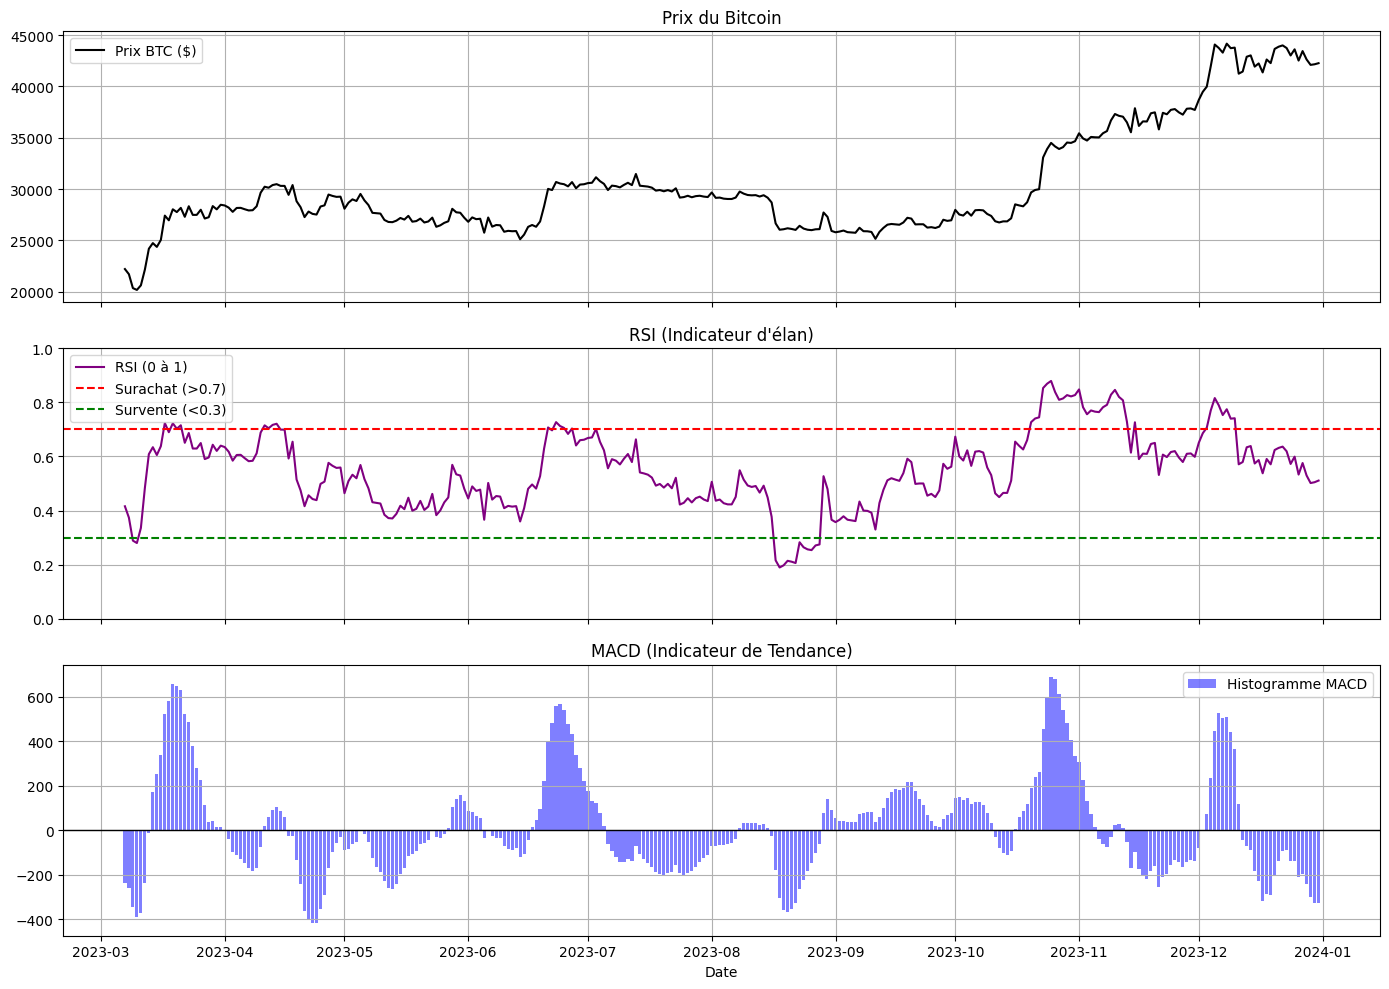

In [ ]:
# On prend les 300 derniers jours pour que le graph soit lisible
subset = df_explore.tail(300)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1. Le Prix
ax1.plot(subset.index, subset['Close'], label='Prix BTC ($)', color='black')
ax1.set_title("Prix du Bitcoin")
ax1.legend()
ax1.grid(True)

# 2. Le RSI (Ce que l'agent regarde pour savoir si c'est trop cher)
ax2.plot(subset.index, subset['rsi'], label='RSI (0 à 1)', color='purple')
ax2.axhline(0.7, color='red', linestyle='--', label='Surachat (>0.7)')
ax2.axhline(0.3, color='green', linestyle='--', label='Survente (<0.3)')
ax2.set_title("RSI (Indicateur d'élan)")
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

# 3. Le MACD (Ce que l'agent regarde pour la tendance)
ax3.bar(subset.index, subset['macd'], label='Histogramme MACD', color='blue', alpha=0.5)
ax3.axhline(0, color='black', linewidth=1)
ax3.set_title("MACD (Indicateur de Tendance)")
ax3.legend()
ax3.grid(True)

plt.xlabel("Date")
plt.tight_layout()
plt.savefig("data_exploration.png")
plt.show()

## 8. Lancement de l'Entraînement (Question 2.4)

Nous entraînons maintenant l'agent DQN sur 100 épisodes. Chaque épisode correspond à un parcours complet des données (2158 jours de trading).

/tmp/ipykernel_19394/238643896.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2018-01-01', end='2024-01-01', interval='1d')
[*********************100%***********************]  1 of 1 completed

Téléchargement des données Bitcoin...
Données prêtes : 2158 jours de trading.


Début de l'entraînement DQN...
Épisode 5/100 | Gain: 17518.83$ | Epsilon: 0.98
Épisode 10/100 | Gain: -51.85$ | Epsilon: 0.95
Épisode 15/100 | Gain: 6315.79$ | Epsilon: 0.93
Épisode 20/100 | Gain: 19579.48$ | Epsilon: 0.90
Épisode 25/100 | Gain: 78765.44$ | Epsilon: 0.88
Épisode 30/100 | Gain: 9592.15$ | Epsilon: 0.86
Épisode 35/100 | Gain: 10263.54$ | Epsilon: 0.84
Épisode 40/100 | Gain: 49102.86$ | Epsilon: 0.82
Épisode 45/100 | Gain: 24241.53$ | Epsilon: 0.80
Épisode 50/100 | Gain: 6583.22$ | Epsilon: 0.78
Épisode 55/100 | Gain: 22744.94$ | Epsilon: 0.76
Épisode 60/100 | Gain: 63938.90$ | Epsilon: 0.74
Épisode 65/100 | Gain: 17679.59$ | Epsilon: 0.72
Épisode 70/100 | Gain: 49151.33$ | Epsilon: 0.70
Épisode 75/100 | Gain: 4844.83$ | Epsilon: 0.69
Épisode 80/100 | Gain: 896.73$ | Epsilon: 0.67
Épisode 85/100 | Gain: 34266.58$ | Epsilon: 0.65
Épisode 90/100 | Gain: 10959.88$ | Epsilon: 0.64
Épisode 95/100 | Gain: 63037.68$ | Epsilon: 0.62
Épisode 100/100 | Gain: 11208.44$ | Epsilon: 0.

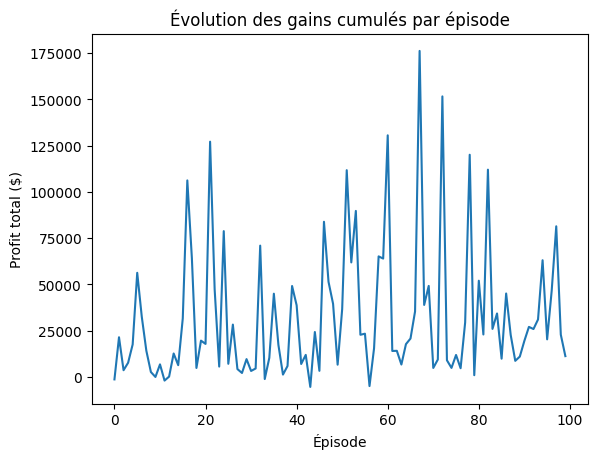

In [8]:
if __name__ == "__main__":
    hist, t = train_agent()
    
    # Petit graph rapide pour vérifier
    plt.plot(hist)
    plt.title("Évolution des gains cumulés par épisode")
    plt.xlabel("Épisode")
    plt.ylabel("Profit total ($)")
    plt.show()

## 9. Analyse des Performances (Question 2.5)

Nous calculons les métriques de performance demandées :
- **Taux de succès** = (Nombre d'épisodes gagnants / Nombre total d'épisodes) × 100
  - Un épisode est "gagnant" si le profit final est positif (> 0$)
- **Temps d'entraînement** : Durée totale en secondes

Nous traçons également les courbes de performance pour visualiser l'évolution de l'agent.

Taux de succès (Episodes gagnants): 94.00%
Temps d'entraînement: 1113.99 secondes


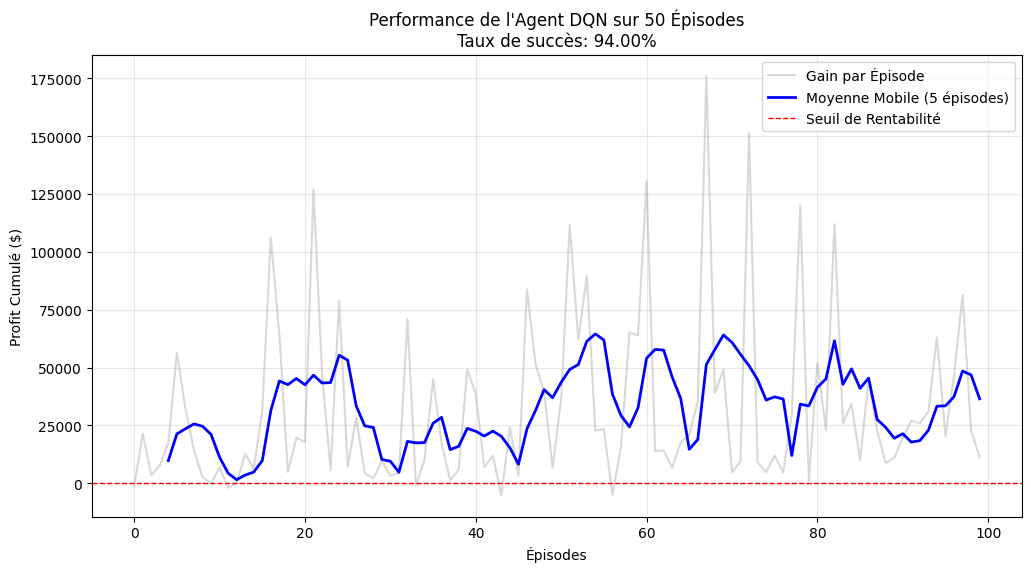

In [9]:
# 1. Calcul de la moyenne mobile 
window_size = 5
moving_avg = pd.Series(hist).rolling(window=window_size).mean()

# 2. Calcul du Taux de Succès
# On considère un "Succès" si l'agent finit l'épisode avec un gain positif (> 0$)
positive_episodes = sum(1 for r in hist if r > 0)
success_rate = (positive_episodes / len(hist)) * 100

print(f"Taux de succès (Episodes gagnants): {success_rate:.2f}%")
print(f"Temps d'entraînement: {t:.2f} secondes")

# 3. Tracé des courbes
plt.figure(figsize=(12, 6))

# Courbe des gains bruts
plt.plot(hist, label='Gain par Épisode', alpha=0.3, color='gray')
# Courbe lissée (Moyenne Mobile)
plt.plot(moving_avg, label=f'Moyenne Mobile ({window_size} épisodes)', color='blue', linewidth=2)

plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Seuil de Rentabilité')
plt.title(f"Performance de l'Agent DQN sur 50 Épisodes\nTaux de succès: {success_rate:.2f}%")
plt.xlabel("Épisodes")
plt.ylabel("Profit Cumulé ($)")
plt.legend()
plt.grid(True, alpha=0.3)

# Sauvegarder pour le rapport
plt.savefig("dqn_performance.png")
plt.show()